# <center>**L'intelligence artificielle au service de la santé**</center>

---

<center> Classification d'images avec Pytorch



</center>

---


# **Connexion au google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Github

/content/drive/MyDrive/Github


In [5]:
! ls

Medical-MNIST-Classification  mednist-classification  resized


In [6]:
%cd /content/drive/MyDrive/Github/mednist-classification

/content/drive/MyDrive/Github/mednist-classification


# **Déroulement du code pour le modèle de deep learning**

## Imports des bibliothèques

In [7]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Vérifions que le GPU est bien disponible
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)


## Mise en place du chemin d'accès

> ### Path du dossier

In [8]:
dataDir = "/content/drive/MyDrive/Github/mednist-classification/resized"               # Le répertoire des données


In [9]:
dataDir # Vérification du chemin d'accès

'/content/drive/MyDrive/Github/mednist-classification/resized'

## Mise en place de nos images

> ### Création d'une fonction pour lire les images, avec la mise en place de six classes

In [10]:
classNames = os.listdir(dataDir)  # Chaque type d'image se trouve dans son propre sous-répertoire
numClass = len(classNames)        # Nombre de types = nombre de sous-répertoires
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # Une liste imbriquée de noms de fichiers
numEach = [len(imageFiles[i]) for i in range(numClass)]     # Un décompte de chaque type d'image
imageFilesList = []               # Création d'une liste non imbriquée de noms de fichiers
imageClass = []                   # Les étiquettes -- le type de chaque image individuelle dans la liste
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Nombre total d'images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # Les dimensions de chaque image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 12024 images in 6 distinct categories
Label names: ['Abdomen', 'Breast', 'Chest', 'CXR', 'Hand', 'Head']
Label counts: [2004, 2004, 2004, 2004, 2004, 2004]
Image dimensions: 64 x 64


> ### Afficher neuf images aléatoires

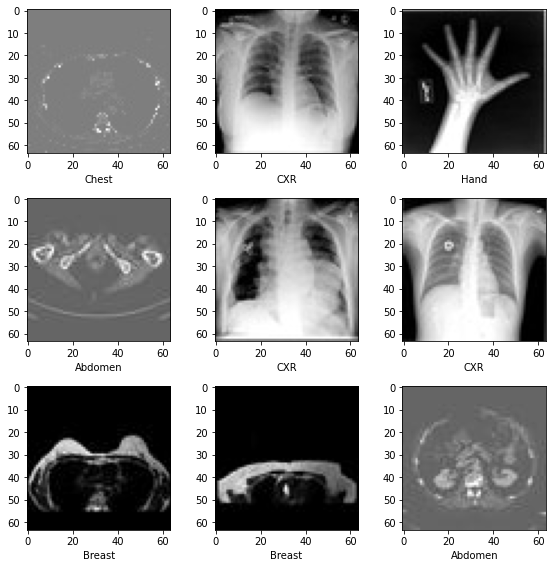

In [11]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Prenez un échantillon aléatoire de 9 images et
    im = Image.open(imageFilesList[k])                      #        les tracer et les étiqueter
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()


> ### Création d'une fonction pour préparer les images

In [12]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Passe une image PIL, retourne un tenseur
    y = toTensor(x)
    if(y.min() < y.max()):  # En supposant que l'image n'est pas vide, redimensionnez-la pour que ses valeurs aillent de 0 à 1.
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Soustraire la valeur moyenne de l'image
    return z

In [13]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Chargement, mise à l'échelle et empilement du tenseur d'image (X)

In [14]:
len(imageTensor) # On vérifie la "longueur", c'est à dire ici le nombre d'imagetensor

12024

In [15]:
classTensor = torch.tensor(imageClass)  # Créer le tenseur d'étiquettes (Y)
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.774; Max = 0.962; Mean = -3.07e-09


> ### Mise en place des sets de validation et de test de nos images

In [16]:
validFrac = 0.1   # Définir la fraction d'images à déplacer vers l'ensemble de données de validation
testFrac = 0.1    # Définir la fraction d'images à déplacer vers l'ensemble de données de test
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Réaffectation aléatoire des images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Comptez le nombre de personnes dans chaque série
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)


Training images = 9604 Validation = 1230 Testing = 1190


In [17]:
trainIds = torch.tensor(trainList)    # Découpez la grande image et les tenseurs d'étiquettes
validIds = torch.tensor(validList)    #        tenseurs de formation, de validation et d'essai
testIds = torch.tensor(testList)

In [18]:
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]

In [19]:
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]

In [20]:
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

## Le modèle d'intelligence artificielle

> ### Définition du modèle dans une classe

In [66]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Passer les dimensions de l'image et le nombre d'étiquettes lors de l'initialisation d'un modèle   
        super(MedNet,self).__init__()  # Étend le nn.Module de base à la classe MedNet
        # Les paramètres définissent ici l'architecture de la partie convolutionnelle du CNN. Chaque pixel de l'image
        # se voit appliquer numConvs convolutions, et convSize est le nombre de pixels environnants inclus dans chaque convolution.
        # dans chaque convolution. Enfin, la formule numNodesToFC calcule les nœuds finaux restants au dernier niveau de convolutions de façon à ce que cette partie du CNN soit la plus complète possible.
        # Enfin, la formule numNodesToFC calcule les nœuds restants au dernier niveau de convolutions afin qu'ils puissent être "aplatis" et introduits dans les couches entièrement connectées par la suite.
        # Chaque convolution rend l'image un peu plus petite (les convolutions ne dépassent pas, par défaut, les bords de l'image).
        # de l'image), ce qui fait que la dimension effective de l'image diminue.
        
        numConvs1 = 8
        convSize1 = 7
        numConvs2 = 16
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 canal -- niveau de gris -- alimente la première convolution. Le même nombre en sortie d'une couche doit être
        # alimenté dans la couche suivante. Ces variables stockent en fait les poids entre les couches du modèle.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # Ces paramètres définissent le nombre de noeuds de sortie de chaque couche entièrement connectée.
        # Chaque couche doit avoir en sortie le même nombre de noeuds que celui avec lequel la couche suivante commence.
        # La couche finale doit avoir un nombre de noeuds de sortie égal au nombre d'étiquettes utilisées.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(noeuds in, noeuds out)
        # Stocke les poids entre les couches entièrement connectées
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # Ceci définit les étapes utilisées dans le calcul de la sortie à partir de l'entrée.
        # Il utilise les poids définis dans la méthode __init__.
        # Chaque affectation de x ici est le résultat de l'alimentation de l'entrée à travers une couche.
        # Nous utilisons ici la fonction d'activation elu, qui est une version plus lisse de la populaire fonction relu.
        
        x = F.elu(self.cnv1(x)) # Alimentation par la première couche convolutive, puis application de l'activation.
        x = F.elu(self.cnv2(x)) # Alimentation par la deuxième couche convolutive, appliquer l'activation
        x = x.view(-1,self.num_flat_features(x)) # Aplatir la couche convolutionnelle en couche entièrement connectée
        x = F.elu(self.ful1(x)) # Passer par la première couche entièrement connectée, appliquer l'activation
        x = F.elu(self.ful2(x)) # Passez par la deuxième couche FC, appliquez la sortie
        x = self.ful3(x)        # Couche finale de FC vers la sortie. Pas d'activation, car elle est utilisée pour calculer les pertes.
        return x

    def num_flat_features(self, x):  # Compter les noeuds individuels dans une couche
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [67]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

>> #### Le résumé de notre modèle

In [68]:
print('Model Details are : ')
print(model)

Model Details are : 
MedNet(
  (cnv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=43264, out_features=400, bias=True)
  (ful2): Linear(in_features=400, out_features=80, bias=True)
  (ful3): Linear(in_features=80, out_features=6, bias=True)
)


> ### Entraînement du modèle

In [69]:
learnRate = 0.01          # Définir un taux d'apprentissage.
maxEpochs = 30            # Nombre maximal d'époques d'apprentissage
t2vRatio = 1.2            # Rapport maximal autorisé entre la perte de validation et la perte de formation
t2vEpochs = 3             # Nombre d'époques consécutives avant de s'arrêter si la perte de validation dépasse la limite ci-dessus.
batchSize = 450          # Taille du lot. Une taille trop importante entraînera une erreur de mémoire insuffisante.
trainBats = nTrain // batchSize       # Nombre de lots d'entraînement par époque. Arrondir à la baisse pour simplifier le dernier lot
validBats = nValid // batchSize       # Lots de validation. Arrondir
testBats = -(-nTest // batchSize)     # Lots d'essai. Arrondir pour tous les inclure
CEweights = torch.zeros(numClass)     # Cela permet de prendre en compte le déséquilibre de l'ensemble de données.
for i in trainY.tolist():             #      En faisant en sorte que les images plus rares comptent davantage pour la perte, 
    CEweights[i].add_(1)              #      nous empêchons le modèle de les ignorer.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Le poids doit être inversement proportionnel au nombre de personnes
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # Les pondérations sont en moyenne de 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialiser un optimiseur


for i in range(maxEpochs):
    model.train()                     # Mettre le modèle en mode formation
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Mélange des données pour rendre les lots aléatoires
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Itération sur les lots
        opti.zero_grad()              # Remise à zéro du gradient accumulé dans l'optimiseur
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Découpage des données mélangées en lots
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) déplace ces lots vers le GPU
        yOut = model(batX)            # Évaluer les prédictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Calculer la perte
        epochLoss += loss.item()      # Ajouter une perte
        loss.backward()               # Perte rétroactive
        opti.step()                   # Mettre à jour les poids du modèle en utilisant l'optimiseur
    validLoss = float(0.)
    permute = torch.randperm(nValid)  # Nous passons exactement par les mêmes étapes, sans backprop / optimisation
    validX = validX[permute,:,:,:]    # afin d'évaluer la perte de validation
    validY = validY[permute]
    model.eval()                      # Mettre le modèle en mode évaluation
    with torch.no_grad():             # Désactiver temporairement la descente de gradient
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Perte moyenne sur les lots et les impressions
    #print("validloss: ", validLoss) vérification qu'on ne divise pas par zéro
    #print("validbats: ", validBats)
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test si la perte de validation dépasse le seuil d'arrêt
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break
    

Epoch =   0; Training loss = 1.5461; Validation loss = 1.1821
Epoch =   1; Training loss = 0.9045; Validation loss = 0.6662
Epoch =   2; Training loss = 0.5191; Validation loss = 0.4234
Epoch =   3; Training loss = 0.3528; Validation loss = 0.3099
Epoch =   4; Training loss = 0.2776; Validation loss = 0.2774
Epoch =   5; Training loss = 0.2336; Validation loss = 0.2307
Epoch =   6; Training loss = 0.2029; Validation loss = 0.1978
Epoch =   7; Training loss = 0.1818; Validation loss = 0.1760
Epoch =   8; Training loss = 0.1630; Validation loss = 0.1550
Epoch =   9; Training loss = 0.1483; Validation loss = 0.1537
Epoch =  10; Training loss = 0.1357; Validation loss = 0.1433
Epoch =  11; Training loss = 0.1252; Validation loss = 0.1177
Epoch =  12; Training loss = 0.1137; Validation loss = 0.1220
Epoch =  13; Training loss = 0.1056; Validation loss = 0.1102
Epoch =  14; Training loss = 0.0969; Validation loss = 0.0998
Epoch =  15; Training loss = 0.0879; Validation loss = 0.0897
Epoch = 

> ### Tests du modèle

In [70]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Créer une matrice de confusion vide
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Mélange des données de test
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Itérer sur les lots de test
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Faire passer le lot de test par le modèle
        pred = yOut.max(1,keepdim=True)[1]              # Générer des prédictions en trouvant les valeurs maximales de Y
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Coller ensemble le réel et le prédit pour
            confuseMtx[j[0],j[1]] += 1                  # créer des paires (row, col), et incrémenter la matrice de confusion
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Additionnez les éléments diagonaux pour compter les prédictions correctes.
print("Le nombre de prédictions justes: ",correct,"sur",nTest)
print("Matrice de confusion:")
print(confuseMtx)
print(classNames)

Le nombre de prédictions justes:  1172 sur 1190
Matrice de confusion:
[[177   0   6   0   0   0]
 [  0 199   0   0   0   0]
 [  2   0 188   0   0   0]
 [  0   0   0 215   1   0]
 [  1   0   0   3 197   1]
 [  1   0   2   0   1 196]]
['Abdomen', 'Breast', 'Chest', 'CXR', 'Hand', 'Head']


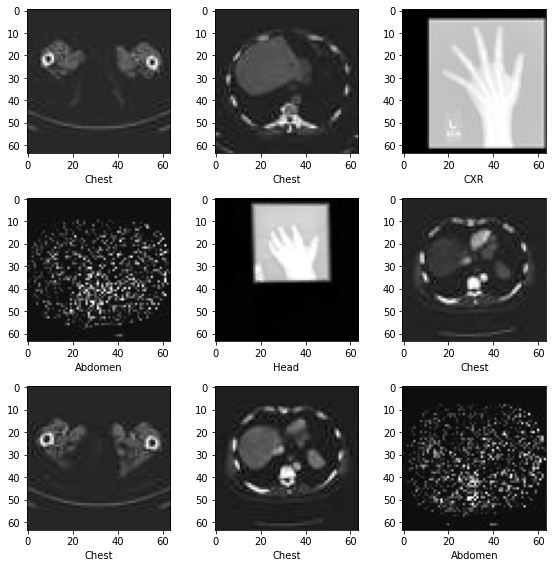

In [71]:
def scaleBack(x):               # Passe un tenseur, retourne un tableau numpy de 0 à 1
    if(x.min() < x.max()):      # En supposant que l'image n'est pas vide, redimensionnez-la pour que ses valeurs aillent de 0 à 1.
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Supprimer le canal (en niveaux de gris de toute façon)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Mélange des données de test
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Itérer sur les lots de test
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Faire passer le lot de test par le modèle
    pred = yOut.max(1)[1].tolist()     # Générer des prédictions en trouvant les valeurs maximales de Y
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Comparez la valeur réelle du y à la prédiction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Étiqueter l'image avec ce que le modèle pense qu'elle est
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()

> ### Exportation du modèle en .onnx

In [27]:
# ! pip install onnx
# Installation pour Google Drive

In [72]:
# On vérifie de nouveau la structure du modèle
model.eval()

MedNet(
  (cnv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=43264, out_features=400, bias=True)
  (ful2): Linear(in_features=400, out_features=80, bias=True)
  (ful3): Linear(in_features=80, out_features=6, bias=True)
)

In [73]:
# On vérifie à quoi ressemble la première couche de layer du modèle
list(model.parameters())[0].shape

torch.Size([8, 1, 7, 7])

In [74]:
# On va définir le dummy input
permute = torch.randperm(nTest,device='cuda')
x = testX[permute,:,:,:]
model.to('cpu')

MedNet(
  (cnv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=43264, out_features=400, bias=True)
  (ful2): Linear(in_features=400, out_features=80, bias=True)
  (ful3): Linear(in_features=80, out_features=6, bias=True)
)

In [75]:
# On exporte le modèle
torch.onnx.export(model, # Modèle
                  x, # Dummy input
                  "MedNet.onnx", # Nom du fichier à exporter
                  verbose=False, 
                  input_names = ['input'],   # Nom en entrée
                  output_names = ['output'], # Nom en sortie
                  export_params=True, # Exporter les paramètres et poids du modèle entraîné
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})